In [1]:
import datetime
import numpy as np
import pickle as pkl
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Users/phuw273g/.conda/envs/untitled/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### simulate data:
__Assume__: 
- there are sensor data from 3 Regulators and 5 Syphons for 2 weeks, with 10 minutes gap
- the normal curve shape is sinusoidal like in the range of 1.75 kpa to 2.25 kpa, the peak happens in the evening
- any points which are too much deviated from the normal curve shape will be considered as anomaly

In [2]:
import random


def simulate_base_daily(gap=10, peaktime=(18, 30, 0), strt_tm=datetime.datetime(2019, 1, 1, 0, 0, 0), plot_=False):
    """
    :param gap: in minute
    :param peaktime: in form of (hour, minute, second)
    :return:
    """
    nts = int(24*60/gap)
    period = np.arange(0, 2*np.pi, 2*np.pi / (nts))
    amp = np.sin(period) / 4 + 2

    df = pd.DataFrame({'pressure': amp, 'ts': 0})
    peak_ind = df[df['pressure'] == df['pressure'].max()].index[0]
    peak_time = datetime.datetime(strt_tm.year, strt_tm.month, strt_tm.day, peaktime[0], peaktime[1], peaktime[2])
    gap_time = datetime.timedelta(seconds=60*gap)
    df.loc[df.index == peak_ind, 'ts'] = peak_time
    df.loc[df.index < peak_ind, 'ts'] = [peak_time-gap_time*i for i in range(1, peak_ind+1)][::-1]
    df.loc[df.index > peak_ind, 'ts'] = [peak_time+gap_time*i for i in range(1, len(df)-peak_ind)]
    df['time'] = df['ts'].apply(lambda x: x.hour*60 + x.minute)

    df2 = pd.DataFrame({'ts': [strt_tm + gap_time * i for i in range(nts)]})
    df2['time'] = df2['ts'].apply(lambda x: x.hour*60 + x.minute)
    df2 = df2.merge(df[['time', 'pressure']], how='left', on='time')

    if plot_:
        plt.plot(df2['time'], df2['pressure'])
        plt.show()
    return df2[['ts', 'pressure']]


def generate_normal_curve(strt_tm=datetime.datetime(2019, 1, 1, 0, 0, 0), duration=datetime.timedelta(days=14),
                          gap=10, peaktime=(18, 30, 0), random_range=0.2, plot_=False):
    base_daily = simulate_base_daily(gap, peaktime, strt_tm, plot_=False)['pressure'].tolist()
    gap_time = datetime.timedelta(seconds=60*gap)
    nts = int(duration / gap_time)
    df = pd.DataFrame({'ts': [strt_tm + gap_time * i for i in range(nts)], 'pressure': base_daily*duration.days})
    val_range = df['pressure'].max() - df['pressure'].min()
    df['noise'] = [random.uniform(-val_range*random_range/2, val_range*random_range/2) for i in range(len(df))]
    df['pressure_normal'] = df['pressure'] + df['noise']
    if plot_:
        plt.plot_date(df['ts'], df['pressure_normal'], linewidth=0.5, linestyle='-', marker='')
        plt.show()
    return df


def add_anomaly(df, anomaly_pct=0.1, anomaly_range=(0.4, 0.8), plot_=True):
    val_range = df['pressure'].max() - df['pressure'].min()
    anomaly_noise = [random.uniform(val_range*anomaly_range[0], val_range*anomaly_range[1]) * 
                     random.sample([-1,1], 1)[0]
                     for i in range(int(len(df)*anomaly_pct))]
    anomaly_noise += [0]*(len(df) - len(anomaly_noise))
    random.shuffle(anomaly_noise)
    len(anomaly_noise)
    df['anomaly_noise'] = anomaly_noise
    df['pressure_abnormal'] = df['anomaly_noise'] + df['pressure_normal']
    df['anomly_flag'] = 0
    df.loc[df['anomaly_noise'] != 0, 'anomly_flag'] = 1
    if plot_:
        plt.figure(figsize=(18, 5))
        plt.plot_date(df['ts'], df['pressure_abnormal'], linewidth=0.5, linestyle='-', marker='', color='green')
        tmp = df[df['anomly_flag'] == 1]
        plt.plot_date(tmp['ts'], tmp['pressure_abnormal'], linewidth=0.5, linestyle='', marker='.', color='red', markersize=3)
        plt.show()
    return df


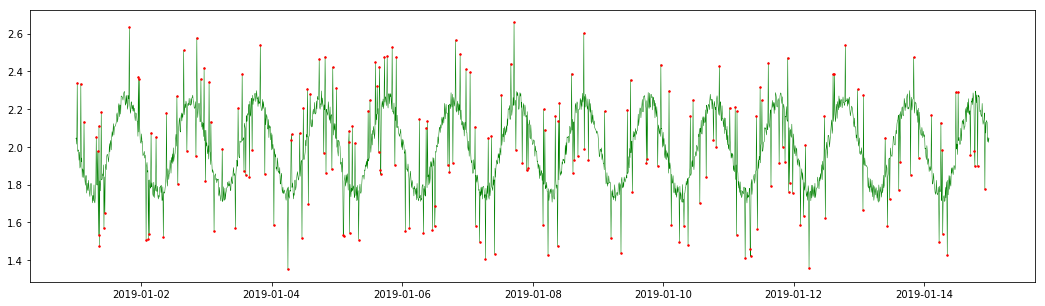

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,0.011019,2.043651,0.000000,2.043651,0
1,2019-01-01 00:10:00,2.021789,0.026121,2.047910,0.000000,2.047910,0
2,2019-01-01 00:20:00,2.010905,0.003732,2.014637,0.000000,2.014637,0
3,2019-01-01 00:30:00,2.000000,0.013785,2.013785,0.325122,2.338908,1
4,2019-01-01 00:40:00,1.989095,-0.012731,1.976365,0.000000,1.976365,0


In [3]:
# test functions
df = generate_normal_curve()
df = add_anomaly(df, plot_=True)
display(df.head())

============== reg_0 ==============


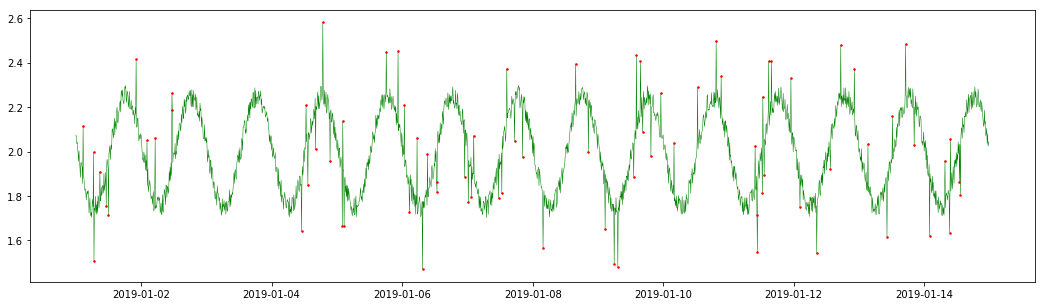

,pressure_abnormal,anomly_flag
0,2.074644,0
1,2.066462,0
2,2.035795,0
3,2.042771,0
4,2.007708,0


============== reg_1 ==============


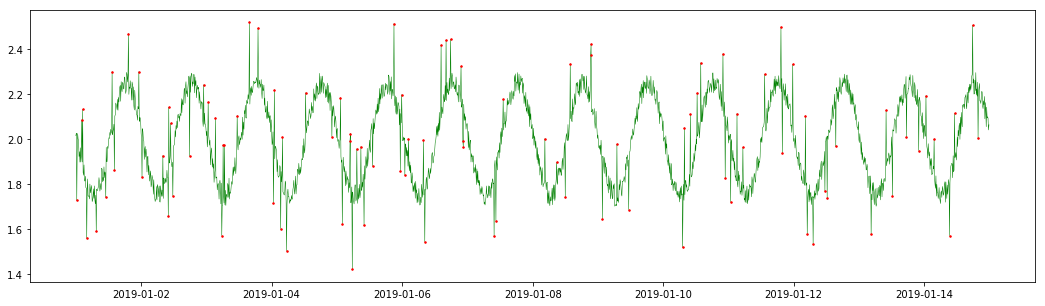

,pressure_abnormal,anomly_flag
0,2.015774,0
1,2.026971,0
2,1.727473,1
3,1.951243,0
4,2.025590,0


============== reg_2 ==============


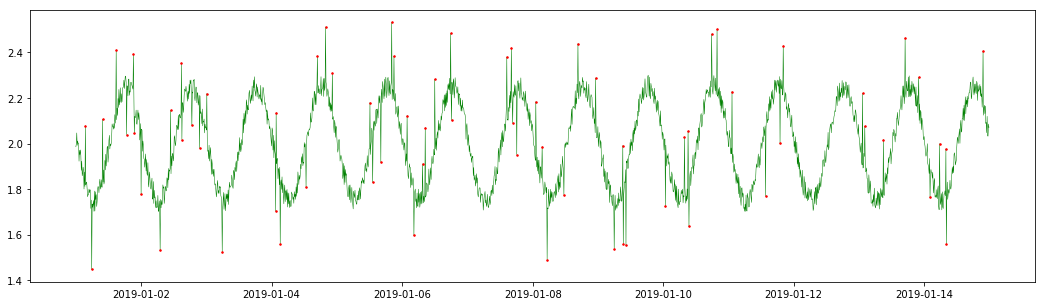

,pressure_abnormal,anomly_flag
0,1.985829,0
1,1.997890,0
2,2.046559,0
3,1.992191,0
4,2.011032,0


============== syph_0 ==============


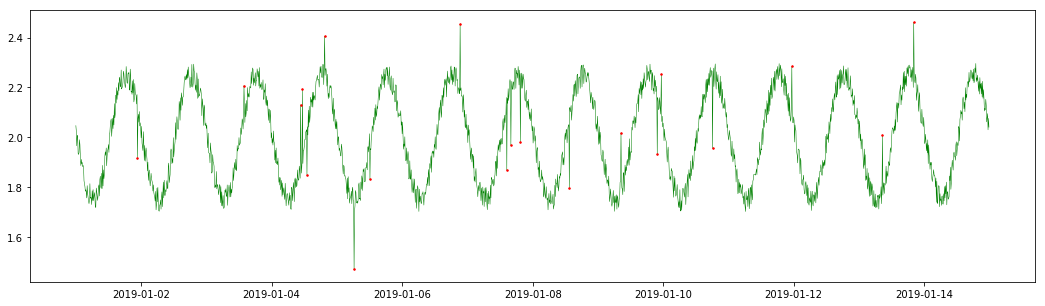

,pressure_abnormal,anomly_flag
0,2.046935,0
1,2.024859,0
2,1.965954,0
3,2.008344,0
4,2.005793,0


============== syph_1 ==============


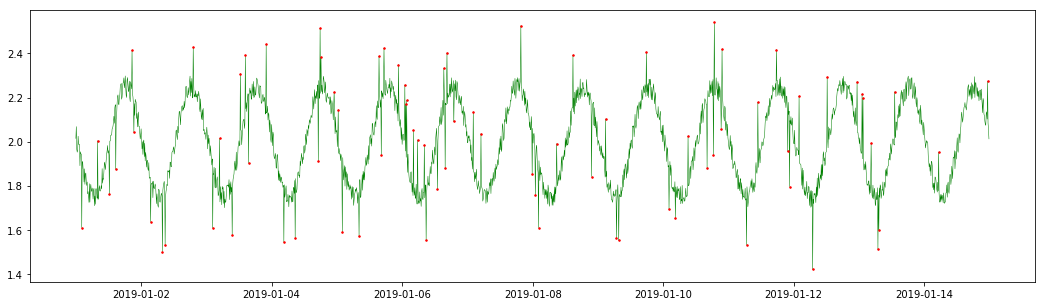

,pressure_abnormal,anomly_flag
0,2.014909,0
1,2.068439,0
2,1.965636,0
3,1.952374,0
4,1.961283,0


============== syph_2 ==============


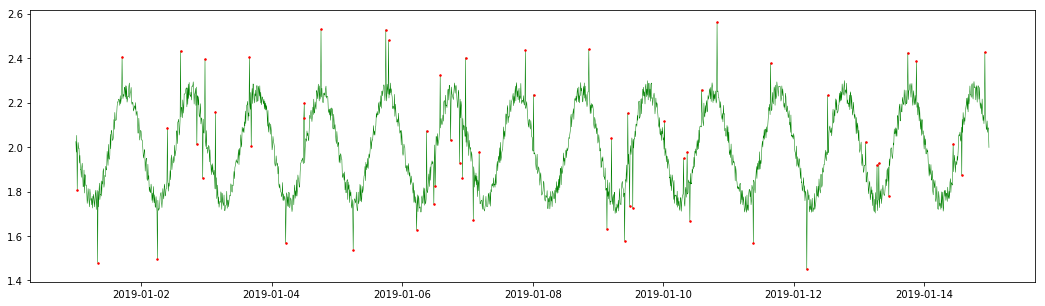

,pressure_abnormal,anomly_flag
0,2.024874,0
1,1.977051,0
2,2.052809,0
3,1.808179,1
4,1.967122,0


============== syph_3 ==============


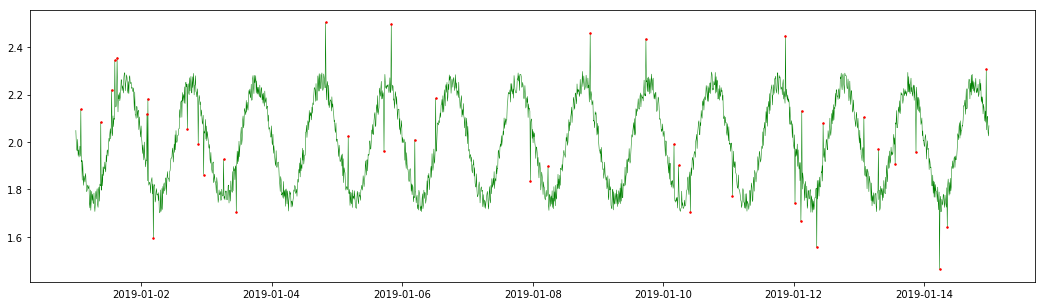

,pressure_abnormal,anomly_flag
0,2.049131,0
1,1.992846,0
2,1.968092,0
3,1.962654,0
4,2.011661,0


============== syph_4 ==============


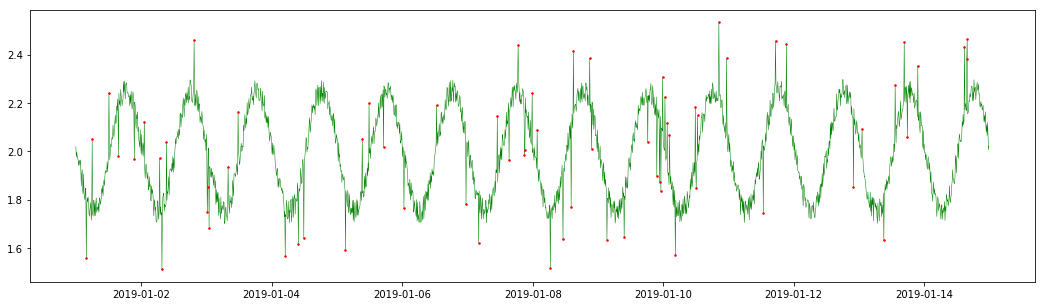

,pressure_abnormal,anomly_flag
0,2.019370,0
1,1.975928,0
2,1.996368,0
3,1.982327,0
4,1.972119,0


In [4]:
# simulate data
data = {}
n_regulators = 3
n_syphons = 5
keys = ['reg_'+str(i) for i in range(n_regulators)] + ['syph_'+str(i) for i in range(n_syphons)]
for k in keys:
    print('============== '+ k + ' ==============')
    data[k] = add_anomaly(generate_normal_curve(), anomaly_pct=random.uniform(0.01, 0.05), 
                          anomaly_range=(0.3, 0.6),
                          plot_=True)[['pressure_abnormal', 'anomly_flag']]
    display(data[k].head())

In [5]:
import pickle as pkl
pkl.dump(data, open(b"simulated_data.pkl","wb"))
